In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from xml.dom import minidom
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data_directory = "./data/pan21-author-profiling-training-2021-03-14/en" 

text_list = []
label_list = []
with open(data_directory+"/truth.txt") as f:
    for l in f.readlines():
        l = l.rstrip().split(":::")
        user_id = l[0]
        label = int(l[1])
        xml_file = minidom.parse(data_directory+"/"+user_id+".xml")
        document_list = xml_file.getElementsByTagName('document')
        aux = []
        for i, doc in enumerate(document_list):
            aux.append(doc.firstChild.nodeValue)
        aux = " ".join(aux)
        text_list.append(aux)
        label_list.append(label)
label_list = np.array(label_list)

print(len(text_list), "Total users")

200 Total users


In [40]:
vocab_size = 20000  
maxlen = 200
test_split = 0.2
val_split = 0.1

x_train_r, x_test_r, y_train, y_test = train_test_split(text_list, label_list, \
                                                        test_size=test_split, random_state=42)

tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train_r)
word_index = tokenizer.word_index
x_train, x_test = tokenizer.texts_to_sequences(x_train_r), tokenizer.texts_to_sequences(x_test_r)

print(len(x_train), "Training sequences")
print(len(x_test), "Testing sequences")
print(vocab_size, "Size of the vocabulary")

x_train = keras.preprocessing.sequence.pad_sequences(x_train)

maxlen = x_train[0].shape[0]

x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

160 Training sequences
40 Testing sequences
20000 Size of the vocabulary


In [57]:
emb_dim = 16

inputs = layers.Input(shape=(maxlen,))
embs = layers.Embedding(vocab_size, emb_dim, input_length=maxlen)(inputs)
convs = embs
for _ in range(1):
    convs = layers.Conv1D(filters=32, kernel_size=3, padding="same")(convs)
    convs = layers.MaxPool1D(pool_size=2, strides=2, padding="valid")(convs)
convs = layers.Conv1D(filters=32, kernel_size=3, padding="same")(convs)
recs = layers.Bidirectional(layers.LSTM(8))(convs)
denses = layers.Dropout(0.2)(recs)
denses = layers.Dense(16, activation="relu")(denses)
denses = layers.Dropout(0.2)(denses)
outputs = layers.Dense(1, activation="sigmoid")(denses)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3918)]            0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 3918, 16)          320000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 3918, 32)          1568      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1959, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1959, 32)          3104      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 16)                2624      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0  

In [58]:
history = model.fit(
    x_train, y_train, batch_size=16, epochs=50, validation_split=0.2
)

Epoch 1/50
8/8 [==============================] - 5s 316ms/step - loss: 0.6941 - accuracy: 0.4085 - val_loss: 0.6926 - val_accuracy: 0.5312
Epoch 2/50
8/8 [==============================] - 1s 131ms/step - loss: 0.6925 - accuracy: 0.5229 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 3/50
8/8 [==============================] - 1s 131ms/step - loss: 0.6890 - accuracy: 0.6438 - val_loss: 0.6935 - val_accuracy: 0.4688
Epoch 4/50
8/8 [==============================] - 1s 132ms/step - loss: 0.6826 - accuracy: 0.6168 - val_loss: 0.6997 - val_accuracy: 0.4688
Epoch 5/50
8/8 [==============================] - 1s 137ms/step - loss: 0.6737 - accuracy: 0.5907 - val_loss: 0.6892 - val_accuracy: 0.5625
Epoch 6/50
8/8 [==============================] - 1s 133ms/step - loss: 0.6254 - accuracy: 0.8446 - val_loss: 0.6973 - val_accuracy: 0.4688
Epoch 7/50
8/8 [==============================] - 1s 137ms/step - loss: 0.5215 - accuracy: 0.9529 - val_loss: 0.6892 - val_accuracy: 0.5312
Epoch 8/50
8/8 [====

In [53]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32)
print("%.3f" % test_acc, "Testing accuracy")

2/2 [==============================] - 1s 104ms/step - loss: 1.7797 - accuracy: 0.4750
0.475 Testing accuracy


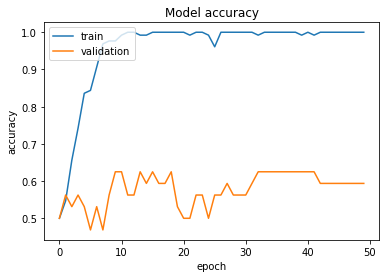

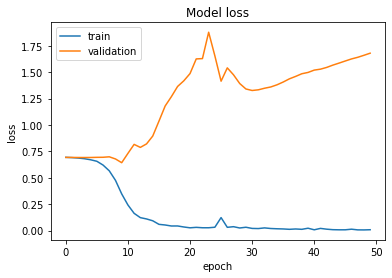

In [54]:
from matplotlib import pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()